In [ ]:
import os
import cv2
import numpy as np
import pickle

directory_query = '../../dataset/qsd1_w2/'

for filename in os.listdir(directory_query):
    if filename.endswith('.jpg'):
        img_path = os.path.join(directory_query, filename)

        # Extract descriptors from image greyscale
        img_grey = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        hist_grey = cv2.calcHist([img_grey], [0], None, [256], [0, 256])
        hist_grey /= hist_grey.sum() # changed "hist.sum() to hist_grey.sum()"

        # Extract descriptors from RGB channels
        histograms_concatenated_rgb = []
        img_BGR = cv2.imread(img_path)
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        for channel in range(3):
            hist = cv2.calcHist([img_RGB], [channel], None, [256], [0, 256])
            hist /= hist.sum()  
            hist = hist.flatten() 
            histograms_concatenated_rgb.append(hist)
            
        concatenated_hist_rgb = np.concatenate(histograms_concatenated_rgb)

        #CieLab
        histograms_concatenated_lab = []
        img_BGR = cv2.imread(img_path)
        img_LAB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2LAB)
        for channel in range(3):
            hist = cv2.calcHist([img_LAB], [channel], None, [256], [0, 256])
            hist /= hist.sum()  
            hist = hist.flatten()  
            histograms_concatenated_lab.append(hist)

        concatenated_hist_lab = np.concatenate(histograms_concatenated_lab)

        #HSV
        img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
        histograms_concatenated_hsv = []
        for channel in range(3):
            hist = cv2.calcHist([img_HSV], [channel], None, [256], [0, 256])
            hist /= hist.sum()  
            hist = hist.flatten()  
            histograms_concatenated_hsv.append(hist)

        concatenated_hist_hsv = np.concatenate(histograms_concatenated_hsv)

        histograms = {
            'grey': hist_grey,
            'hist_RGB': concatenated_hist_rgb,
            'hist_LAB': concatenated_hist_lab,
            'hist_HSV': concatenated_hist_hsv,
        }

        pkl_filename = os.path.splitext(filename)[0] + '.pkl'
        pkl_path = os.path.join(directory_query, pkl_filename)

        with open(pkl_path, 'wb') as pkl_file:
            pickle.dump(histograms, pkl_file)

In [ ]:
def spatial_pyramid_histogram(image, levels=2, hist_size=[8, 8, 8], ranges=[0, 256, 0, 256, 0, 256], channels=[0, 1, 2]):
    """
    Compute a spatial pyramid representation of histograms.
    
    Parameters:
        image: Input image for which spatial pyramid is computed.
        levels: Number of pyramid levels.
        hist_size: Number of histogram bins for each channel.
        ranges: Value range for each channel.
        channels: Channels to be used for the histogram.
    
    Returns:
        pyramid_hist: Concatenated histograms for the entire pyramid.
    """
    pyramid_hist = []
    h, w = image.shape[:2]  # Get the height and width of the image

    # Loop through each level in the pyramid
    for level in range(levels + 1):
        num_blocks = 2 ** level  # Number of blocks per dimension
        block_h, block_w = h // num_blocks, w // num_blocks  # Block size

        for i in range(num_blocks):
            for j in range(num_blocks):
                # Define the block region
                block = image[i * block_h:(i + 1) * block_h, j * block_w:(j + 1) * block_w]
                
                # Compute the histogram for the block
                block_hist = cv2.calcHist([block], channels, None, hist_size, ranges)
                block_hist/=block_hist.sum()
                pyramid_hist.append(block_hist)

    # Concatenate all histograms into a single feature vector
    pyramid_hist = np.concatenate(pyramid_hist)
    return pyramid_hist

In [1]:
# Load a sample image
image = cv2.imread("../../dataset/qsd1_w2/00000.jpg")

# Compute spatial pyramid histogram (example: 3 levels with 3D histograms in RGB)
spatial_hist = spatial_pyramid_histogram(image, levels=2, hist_size=[8, 8, 8], ranges=[0, 256, 0, 256, 0, 256], channels=[0, 1, 2])

print(f"Spatial pyramid histogram feature vector length: {len(spatial_hist)}")

NameError: name 'cv2' is not defined

In [16]:
import cv2
import numpy as np
import os
import pickle

def spatial_pyramid_histogram(image, levels=2, hist_size=8, hist_range=[0,256]):
    """
    Compute a spatial pyramid representation of histograms, with concatenation of histograms per channel.
    Level zero has 1 block. 2^0=1 so blocks 1*1=1
    Level one has 4 blocks. 2^1=2 so blocks 2*2=4
    Level two has 16 blocks. 2^2=4 so blocks 4*4=16
    """

    pyramid_hist = []
    h, w = image.shape[:2]  # Get the height and width of the image
    channels = 1 if len(image.shape) == 2 else image.shape[2]  # Check number of channels

    # Loop through each level in the pyramid
    for level in range(levels + 1):
        num_blocks = 2 ** level  
        block_h, block_w = h // num_blocks, w // num_blocks  # Block size

        for i in range(num_blocks):
            for j in range(num_blocks):
                # Define the block region
                block = image[i * block_h:(i + 1) * block_h, j * block_w:(j + 1) * block_w]
                #print(f'block ' + str(i) +' : '+ str(j))
                # Compute histograms depending on the number of channels
                block_hist = []
                if channels == 1:
                    # Single-channel image (grayscale)
                    hist = cv2.calcHist([block], [0], None, [hist_size], hist_range)
                    hist /= hist.sum()  # Normalize the histogram
                    block_hist.append(hist.flatten())
                else:
                    # Multi-channel image (e.g., BGR)
                    for ch in range(channels):
                        #print(f'channel'+str(ch))
                        hist = cv2.calcHist([block], [ch], None, [hist_size], hist_range)
                        hist /= hist.sum()  # Normalize the histogram
                        block_hist.append(hist.flatten())

                # Concatenate histograms for this block
                block_hist = np.concatenate(block_hist)
                pyramid_hist.append(block_hist)

    # Concatenate all block histograms into a single feature vector
    pyramid_hist = np.concatenate(pyramid_hist)
    return pyramid_hist


def process_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory_path, filename)
            # Extract descriptors from image greyscale
            img_grey = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # Compute spatial pyramid histogram 
            hist_grey_8 = spatial_pyramid_histogram(img_grey, levels=2, hist_size=8, hist_range=[0, 256])
            hist_grey_128 = spatial_pyramid_histogram(img_grey, levels=2, hist_size=128, hist_range=[0, 256])
            hist_grey_256 = spatial_pyramid_histogram(img_grey, levels=2, hist_size=256, hist_range=[0, 256])

            # Extract descriptors from RGB channels
            img_BGR = cv2.imread(img_path)
            img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
            hist_RGB_8 = spatial_pyramid_histogram(img_RGB, levels=2, hist_size=8, hist_range=[0, 256])
            hist_RGB_128 = spatial_pyramid_histogram(img_RGB, levels=2, hist_size=128, hist_range=[0, 256])
            hist_RGB_256 = spatial_pyramid_histogram(img_RGB, levels=2, hist_size=256, hist_range=[0, 256])

            #CieLab
            img_LAB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2LAB)
            hist_LAB_8 = spatial_pyramid_histogram(img_LAB, levels=2, hist_size=8, hist_range=[0, 256])
            hist_LAB_128 = spatial_pyramid_histogram(img_LAB, levels=2, hist_size=128, hist_range=[0, 256])
            hist_LAB_256 = spatial_pyramid_histogram(img_LAB, levels=2, hist_size=256, hist_range=[0, 256])

            #HSV
            img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
            hist_HSV_8 = spatial_pyramid_histogram(img_HSV, levels=2, hist_size=8, hist_range=[0, 256])
            hist_HSV_128 = spatial_pyramid_histogram(img_HSV, levels=2, hist_size=128, hist_range=[0, 256])
            hist_HSV_256 = spatial_pyramid_histogram(img_HSV, levels=2, hist_size=256, hist_range=[0, 256])


            histograms = {
                'hist_grey_8': hist_grey_8,
                'hist_grey_128': hist_grey_128,
                'hist_grey_256': hist_grey_256,
                'hist_RGB_8': hist_RGB_8,
                'hist_RGB_128': hist_RGB_128,
                'hist_RGB_256': hist_RGB_256,
                'hist_LAB_8': hist_LAB_8,
                'hist_LAB_128': hist_LAB_128,
                'hist_LAB_256': hist_LAB_256,
                'hist_HSV_8': hist_HSV_8,
                'hist_HSV_128': hist_HSV_128,
                'hist_HSV_256': hist_HSV_256,
            }

            # Verify if the folder is BBDD to add '_w2' to the pickle path so to no delete the pickles from the last week
            if directory_path == "../../data/BBDD":
                pkl_filename = os.path.splitext(filename)[0] + '_w2.pkl'
            else:
                pkl_filename = os.path.splitext(filename)[0] + '.pkl'

            pkl_path = os.path.join(directory_path, pkl_filename)
            #print(pkl_path)
            with open(pkl_path, 'wb') as pkl_file:
                pickle.dump(histograms, pkl_file)

# process both folders
directory_query1 = "../../datasets/qsd1_w2/"
directory_query2 = "../../data/BBDD"

print("Processing directory 1:")
process_directory(directory_query1)

print("Processing directory 2:")
process_directory(directory_query2)

Processing directory 1:
Processing directory 2:


In [31]:
import re
import os
import pickle

import utils

directory = '../../datasets/qsd1_w2/'
directory_bbdd = '../../data/BBDD/'

def extract_number_from_filename(filename):
    '''Function to extract the number of the image'''
    match = re.search(r'bbdd_(\d{5})_w2\.pkl', filename)
    if match:
        return int(match.group(1))

def extract_number_from_filename_qsd1_w1(filename):
    '''Function to extract the number of the image'''
    match = re.search(r'(\d+)\.pkl', filename)
    if match:
        return int(match.group(1))

# Define the histogram keys and distance functions
histogram_keys = [
    'hist_grey_8', 'hist_grey_128', 'hist_grey_256',
    'hist_RGB_8', 'hist_RGB_128', 'hist_RGB_256',
    'hist_LAB_8', 'hist_LAB_128', 'hist_LAB_256',
    'hist_HSV_8', 'hist_HSV_128', 'hist_HSV_256'
]

distance_functions = {
    'our_metric': utils.our_metric,
    'X2_distance': utils.X2_distance,
    'L1_dist': utils.L1_dist,
    'euc_dist': utils.euc_dist,
    'histogram_similarity': utils.histogram_similiarity,
    'hellinger_kernel': utils.hellinger_kernel
}

# Loop over each histogram key
for hist_key in histogram_keys:
    print(f"Processing histogram key: {hist_key}")
    
    # Loop over each distance function
    for metric_name, metric_func in distance_functions.items():
        print(f"  Using distance function: {metric_name}")

        list_results_k_1 = []
        list_results_k_5 = []

        files = os.listdir(directory)
        files_sorted = sorted(files)

        # Loop over each file to compare
        for file_compare_image in files_sorted:
            if file_compare_image.endswith('.pkl') and file_compare_image != 'gt_corresps.pkl':
                pkl_grey_path = os.path.join(directory, file_compare_image)
                with open(pkl_grey_path, 'rb') as pkl_file:
                    histograms_first = pickle.load(pkl_file)

                distances = []
                index_qsd1_w1 = extract_number_from_filename_qsd1_w1(file_compare_image)

                # Loop over each file in the database
                for filename in os.listdir(directory_bbdd):
                    if filename.endswith('_w2.pkl') and filename != 'relationships.pkl':
                        pkl_path = os.path.join(directory_bbdd, filename)

                        with open(pkl_path, 'rb') as pkl_file:
                            histograms = pickle.load(pkl_file)

                        # Calculate distance for the current histogram key
                        histogram_first = histograms_first[hist_key]
                        histogram = histograms[hist_key]

                        # Calculate the distance
                        distance = metric_func(histogram_first, histogram)
                        index = extract_number_from_filename(filename)

                        distances.append((distance, index))

                # Sort the distances and select the top k results
                distances.sort(key=lambda x: x[0])  # Sort by distance (lowest first)
                top_k_1_result = [distances[0][1]]
                top_k_5_results = [index for _, index in distances[:5]]

                # Save the indices in a list
                list_results_k_1.append(top_k_1_result)
                list_results_k_5.append(top_k_5_results)

        # Flatten the results for comparison with ground truth
        predicted_flattened_k_5 = [p for p in list_results_k_5]

        with open(f'../../datasets/qsd1_w2/gt_corresps.pkl', 'rb') as f:
            ground_truth = pickle.load(f)

        # Print the MAP@k results for the current histogram key with the current distance function
        mapk_k1 = utils.mapk(ground_truth, list_results_k_1, k=1)
        mapk_k5 = utils.mapk(ground_truth, predicted_flattened_k_5, k=5)
        print(f"    {hist_key} with {metric_name}; k=1 mapk: {mapk_k1}")
        print(f"    {hist_key} with {metric_name}; k=5 mapk: {mapk_k5}")

print("Finished processing all histogram keys and distance functions.")

Processing histogram key: hist_grey_8
  Using distance function: our_metric
    hist_grey_8 with our_metric; k=1 mapk: 0.5333333333333333
    hist_grey_8 with our_metric; k=5 mapk: 0.5788888888888889
  Using distance function: X2_distance
    hist_grey_8 with X2_distance; k=1 mapk: 0.6333333333333333
    hist_grey_8 with X2_distance; k=5 mapk: 0.64
  Using distance function: L1_dist
    hist_grey_8 with L1_dist; k=1 mapk: 0.6333333333333333
    hist_grey_8 with L1_dist; k=5 mapk: 0.64
  Using distance function: euc_dist
    hist_grey_8 with euc_dist; k=1 mapk: 0.5333333333333333
    hist_grey_8 with euc_dist; k=5 mapk: 0.5666666666666667
  Using distance function: histogram_similarity
    hist_grey_8 with histogram_similarity; k=1 mapk: 0.0
    hist_grey_8 with histogram_similarity; k=5 mapk: 0.0
  Using distance function: hellinger_kernel
    hist_grey_8 with hellinger_kernel; k=1 mapk: 0.6333333333333333
    hist_grey_8 with hellinger_kernel; k=5 mapk: 0.6333333333333333
Processing h

In [30]:
 # Loop over each file in the database
for filename in os.listdir(directory_bbdd):
        if filename.endswith('_w2.pkl') and filename != 'relationships.pkl':
                pkl_path = os.path.join(directory_bbdd, filename)

                with open(pkl_path, 'rb') as pkl_file:
                    histograms = pickle.load(pkl_file)
                print(pkl_path)

../../data/BBDD/bbdd_00000_w2.pkl
../../data/BBDD/bbdd_00001_w2.pkl
../../data/BBDD/bbdd_00002_w2.pkl
../../data/BBDD/bbdd_00003_w2.pkl
../../data/BBDD/bbdd_00004_w2.pkl
../../data/BBDD/bbdd_00005_w2.pkl
../../data/BBDD/bbdd_00006_w2.pkl
../../data/BBDD/bbdd_00007_w2.pkl
../../data/BBDD/bbdd_00008_w2.pkl
../../data/BBDD/bbdd_00009_w2.pkl
../../data/BBDD/bbdd_00010_w2.pkl
../../data/BBDD/bbdd_00011_w2.pkl
../../data/BBDD/bbdd_00012_w2.pkl
../../data/BBDD/bbdd_00013_w2.pkl
../../data/BBDD/bbdd_00014_w2.pkl
../../data/BBDD/bbdd_00015_w2.pkl
../../data/BBDD/bbdd_00016_w2.pkl
../../data/BBDD/bbdd_00017_w2.pkl
../../data/BBDD/bbdd_00018_w2.pkl
../../data/BBDD/bbdd_00019_w2.pkl
../../data/BBDD/bbdd_00020_w2.pkl
../../data/BBDD/bbdd_00021_w2.pkl
../../data/BBDD/bbdd_00022_w2.pkl
../../data/BBDD/bbdd_00023_w2.pkl
../../data/BBDD/bbdd_00024_w2.pkl
../../data/BBDD/bbdd_00025_w2.pkl
../../data/BBDD/bbdd_00026_w2.pkl
../../data/BBDD/bbdd_00027_w2.pkl
../../data/BBDD/bbdd_00028_w2.pkl
../../data/BBD

In [ ]:
import cv2
import numpy as np
import os
import pickle

def spatial_pyramid_histogram(image, levels=2, hist_size=8, hist_range=[0,256]):
    """
    Compute a spatial pyramid representation of histograms, with concatenation of histograms per channel.
    Level zero has 1 block. 2^0=1 so blocks 1*1=1
    Level one has 4 blocks. 2^1=2 so blocks 2*2=4
    Level two has 16 blocks. 2^2=4 so blocks 4*4=16
    """

    pyramid_hist = []
    h, w = image.shape[:2]  # Get the height and width of the image

    # Loop through each level in the pyramid
    for level in range(levels + 1):
        num_blocks = 2 ** level  
        block_h, block_w = h // num_blocks, w // num_blocks  # Block size

        for i in range(num_blocks):
            for j in range(num_blocks):
                # Define the block region
                block = image[i * block_h:(i + 1) * block_h, j * block_w:(j + 1) * block_w]
                #print(f'block ' + str(i) +' : '+ str(j))
                # Compute histograms depending on the number of channels
                block_hist = []

                # Multi-channel image (e.g., BGR)
                for ch in range(3):
                    #print(f'channel'+str(ch))
                    hist = cv2.calcHist([block], [ch], None, [hist_size], hist_range)
                    hist /= hist.sum()  # Normalize the histogram
                    block_hist.append(hist.flatten())

                # Concatenate histograms for this block
                block_hist = np.concatenate(block_hist)
                pyramid_hist.append(block_hist)

    # Concatenate all block histograms into a single feature vector
    pyramid_hist = np.concatenate(pyramid_hist)
    return pyramid_hist

def process_directory(img_path):
            # Extract descriptors from image greyscale
            img_grey = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Extract descriptors from RGB channels
            img_BGR = cv2.imread(img_path)
            img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
            hist_RGB_8 = spatial_pyramid_histogram(img_RGB, levels=2, hist_size=8, hist_range=[0, 256])
            hist_RGB_128 = spatial_pyramid_histogram(img_RGB, levels=2, hist_size=128, hist_range=[0, 256])
            hist_RGB_256 = spatial_pyramid_histogram(img_RGB, levels=2, hist_size=256, hist_range=[0, 256])

            #CieLab
            img_BGR = cv2.imread(img_path)
            img_LAB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2LAB)
            hist_LAB_8 = spatial_pyramid_histogram(img_LAB, levels=2, hist_size=8, hist_range=[0, 256])
            hist_LAB_128 = spatial_pyramid_histogram(img_LAB, levels=2, hist_size=128, hist_range=[0, 256])


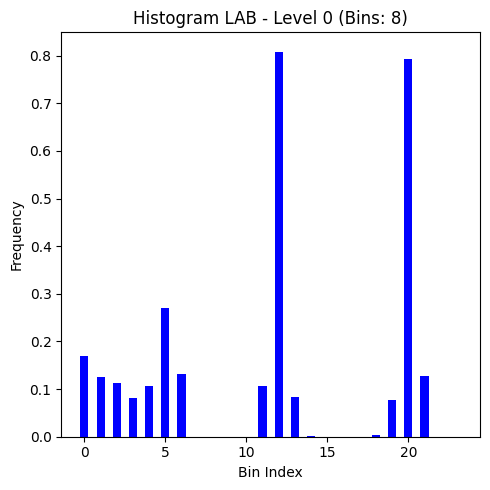

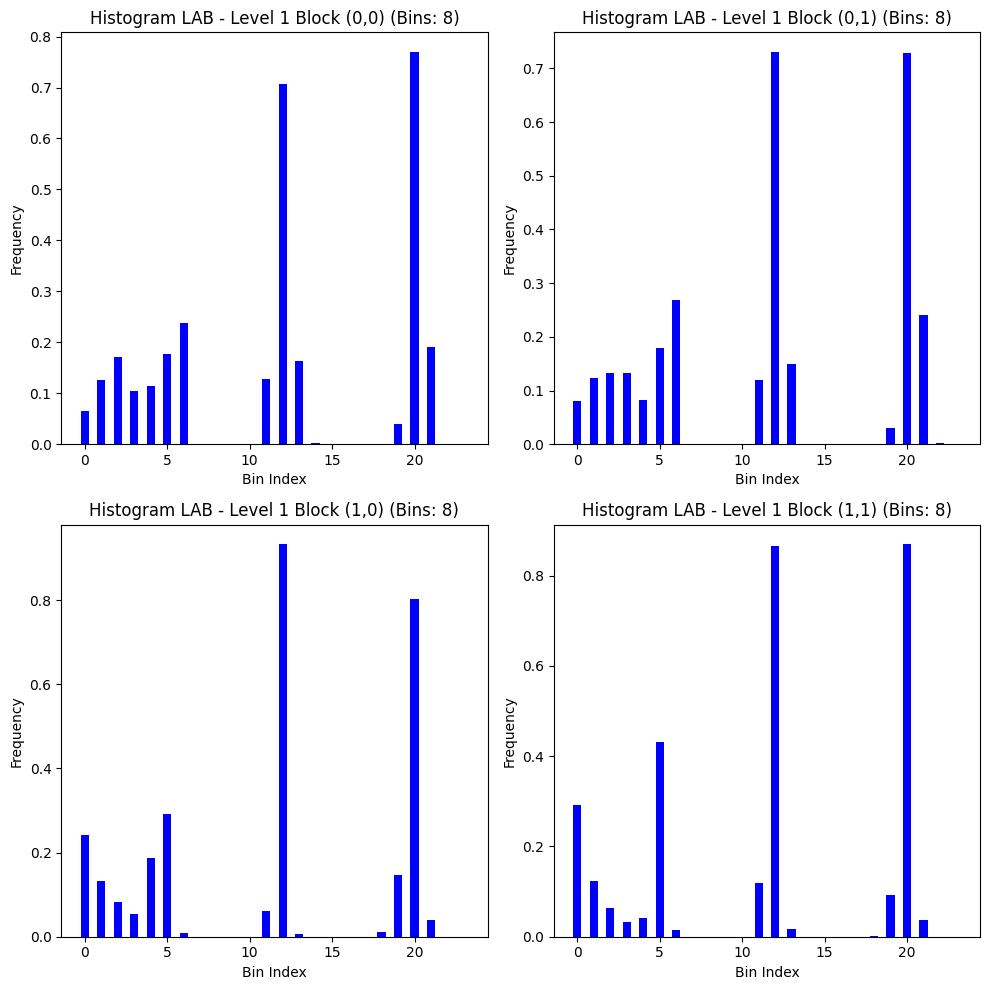

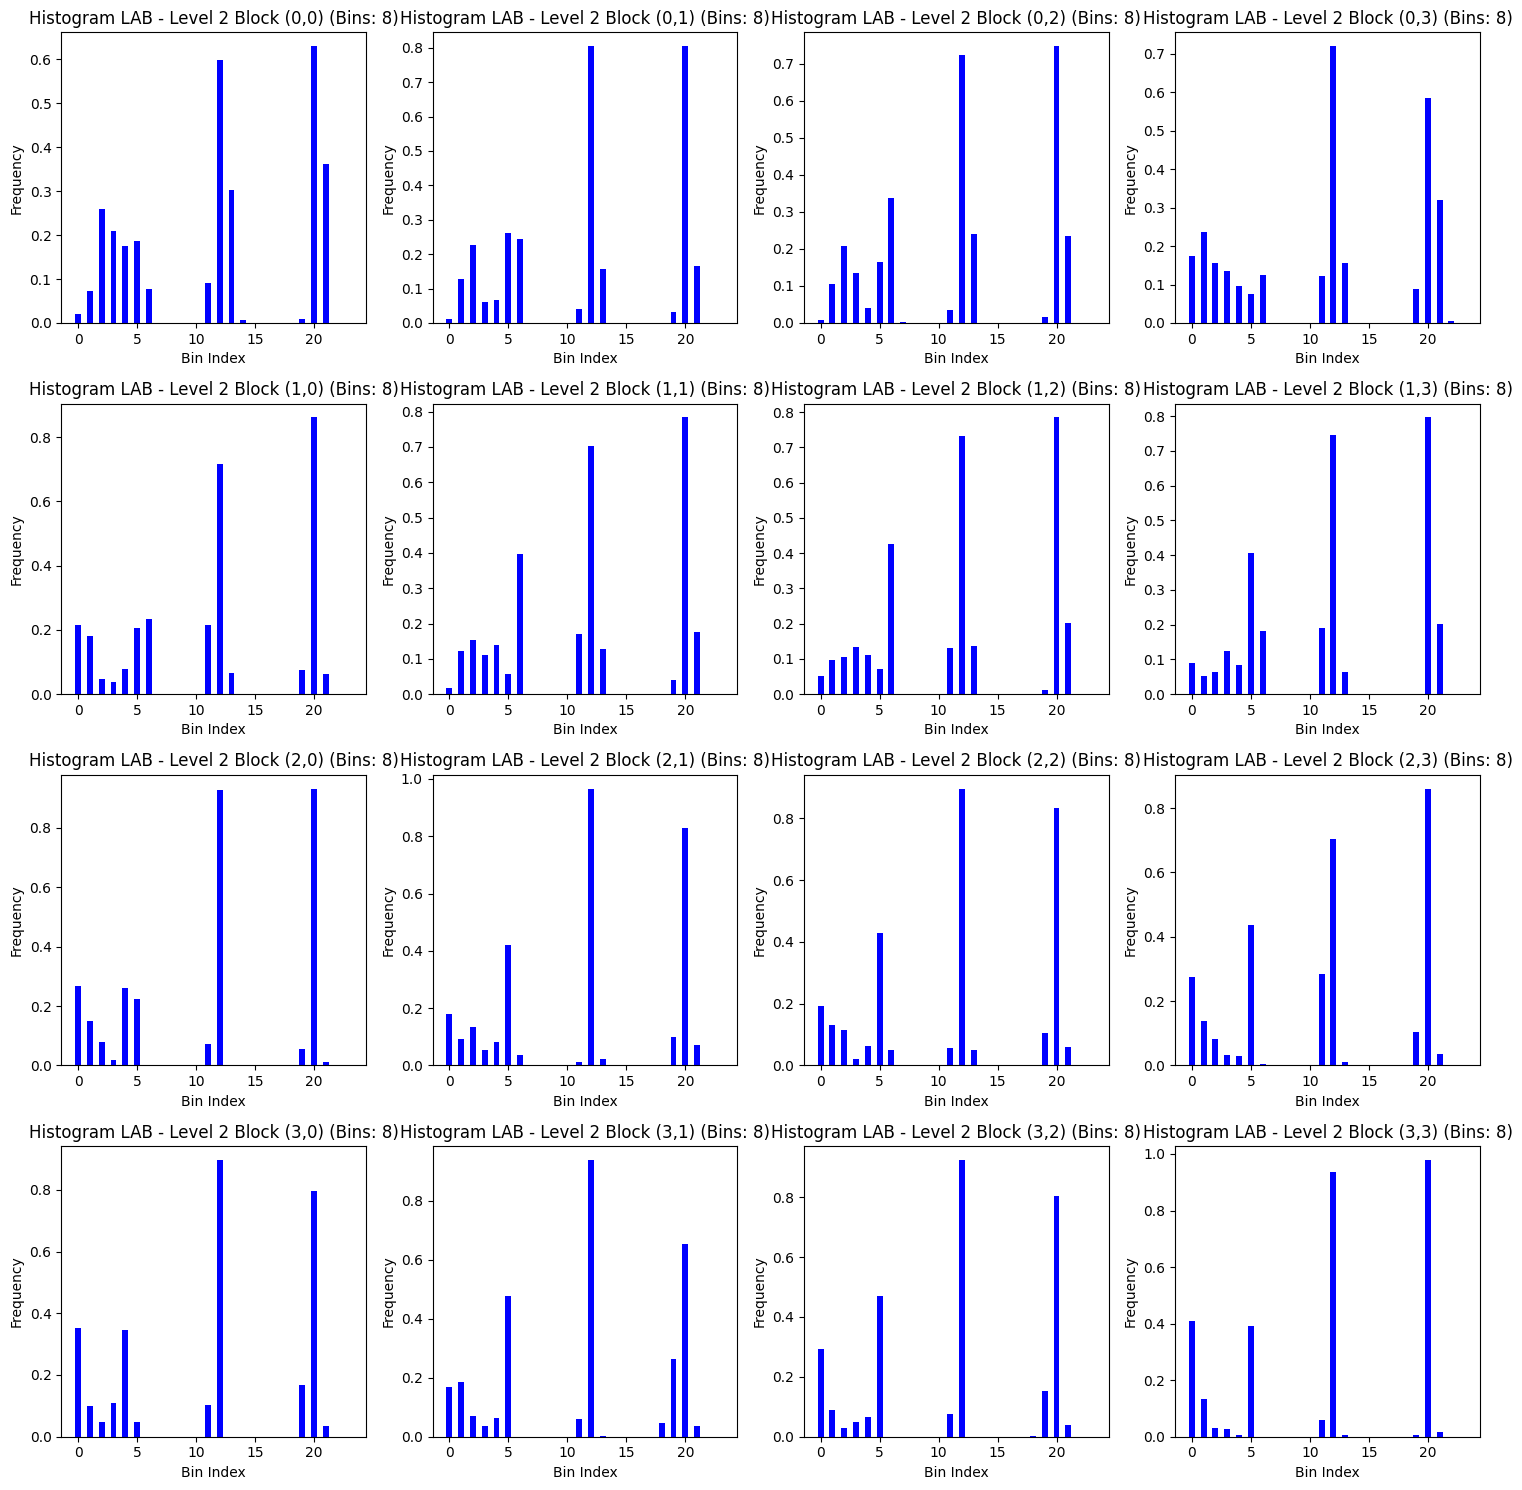

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def spatial_pyramid_histogram(image, levels=2, hist_size=8, hist_range=[0,256]):
    """
    Compute a spatial pyramid representation of histograms, with concatenation of histograms per channel.
    """
    pyramid_hist = []
    h, w = image.shape[:2]  # Get the height and width of the image

    # Loop through each level in the pyramid
    for level in range(levels + 1):
        num_blocks = 2 ** level  
        block_h, block_w = h // num_blocks, w // num_blocks  # Block size

        for i in range(num_blocks):
            for j in range(num_blocks):
                # Define the block region
                block = image[i * block_h:(i + 1) * block_h, j * block_w:(j + 1) * block_w]
                block_hist = []

                # Multi-channel image (e.g., Lab)
                for ch in range(3):  # LAB has 3 channels
                    hist = cv2.calcHist([block], [ch], None, [hist_size], hist_range)
                    hist /= hist.sum()  # Normalize the histogram
                    block_hist.append(hist.flatten())

                # Concatenate histograms for this block
                block_hist = np.concatenate(block_hist)
                pyramid_hist.append(block_hist)

    return pyramid_hist

def plot_histogram(histogram, hist_size, title, ax):
    """
    Helper function to plot a histogram on a given axis.
    """
    ax.bar(range(len(histogram)), histogram, width=0.5, color='blue')
    ax.set_title(f"Histogram {title} (Bins: {hist_size})")
    ax.set_xlabel('Bin Index')
    ax.set_ylabel('Frequency')

def process_and_visualize_lab_histograms(img_path):
    # Read the image
    img_BGR = cv2.imread(img_path)

    # Convert image to CIE Lab and extract histograms
    img_LAB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2LAB)
    hist_LAB = spatial_pyramid_histogram(img_LAB, levels=2, hist_size=8, hist_range=[0, 256])

    # Level 0 (1 block)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plot_histogram(hist_LAB[0], 8, 'LAB - Level 0', ax)
    plt.tight_layout()
    plt.savefig('../../histograms/week2/hist_LAB_level0.png')  # Guardar el gráfico
    plt.show()

    # Level 1 (4 blocks in 2x2 grid)
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    block_idx = 1
    for i in range(2):
        for j in range(2):
            plot_histogram(hist_LAB[block_idx], 8, f'LAB - Level 1 Block ({i},{j})', axs[i, j])
            block_idx += 1
    plt.tight_layout()
    plt.savefig('../../histograms/week2/hist_LAB_level1.png')  # Guardar el gráfico
    plt.show()

    # Level 2 (16 blocks in 4x4 grid)
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    block_idx = 5  # Starts after the blocks in level 0 and 1
    for i in range(4):
        for j in range(4):
            plot_histogram(hist_LAB[block_idx], 8, f'LAB - Level 2 Block ({i},{j})', axs[i, j])
            block_idx += 1
    plt.tight_layout()
    plt.savefig('../../histograms/week2/hist_LAB_level2.png')  # Guardar el gráfico
    plt.show()
# Example usage
img_path = '../../data/BBDD/bbdd_00000.jpg'  # Provide your image path
process_and_visualize_lab_histograms(img_path)


In [4]:
import pickle

# Ruta al archivo pickle
pickle_file_path = '../../datasets/qsd2_w1/gt_corresps.pkl'

# Abre el archivo en modo lectura binaria y carga el contenido
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

# Imprime el contenido del pickle
print(data)

[[100], [219], [250], [25], [22], [215], [81], [184], [177], [203], [128], [130], [225], [76], [282], [23], [130], [227], [86], [27], [41], [258], [93], [58], [142], [241], [258], [199], [12], [67]]
